# Back to the widget production problem
Let's go back to the Opti 101/201 classic: Widget production and distribution. Use the code below as the base model for this problem.

In [ ]:
%pip install gurobipy

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

$$
\begin{align*} 
{\rm minimize} \space &\sum_{p,d}c_{p,d}x_{p,d}, \forall p \in P, d \in D\\ 
\sum_{p}&x_{p,d} \ge n_d, \forall d \in D \\ 
\sum_{d}&x_{p,d} \le m_p, \forall p \in P \\ 
\sum_{d}&x_{p,d} \ge a*m_p, \forall p \in P\\ 
&x_{p,d} \in \{0\} \cup [30, u_p]
\end{align*}
$$


<div class="alert alert-warning">
    <strong>Note!</strong>
    <p>Make sure to run the next two code cells to get a baseline for the original problem.</p>
</div>


In [2]:
# read in transportation cost data
path = 'https://raw.githubusercontent.com/Gurobi/modeling-examples/master/optimization101/Modeling_Session_1/'
transp_cost = pd.read_csv(path + 'cost.csv')

# get production and distribution locations from data frame
production = list(transp_cost['production'].unique())
distribution = list(transp_cost['distribution'].unique())
transp_cost = transp_cost.set_index(['production','distribution']).squeeze()

max_prod = pd.Series([180,200,140,80,180], index = production, name = "max_production")
n_demand = pd.Series([89,95,121,101,116,181], index = distribution, name = "demand")

# min overall production requirement, and min shipment amount from p to d
frac = 0.75
C = 30

Code for the 'gurobipy' model:

In [9]:
m = gp.Model('widgets')
m.setParam('OutputFlag',0)
m.setParam('PoolSearchMode',2)   
m.setParam('PoolSolutions',2)   

# decision vars
x = m.addVars(production, distribution, vtype=GRB.SEMICONT, lb = C, name = 'prod_ship')

# constraints
can_produce = m.addConstrs((gp.quicksum(x[p,d] for d in distribution) <= max_prod[p] for p in production), name = 'can_produce')
must_produce = m.addConstrs((gp.quicksum(x[p,d] for d in distribution) >= frac*max_prod[p] for p in production), name = 'must_produce')
meet_demand = m.addConstrs((x.sum('*', d) >= n_demand[d] for d in distribution), 'meet_demand')

# objective
total_cost = gp.quicksum(transp_cost[p,d]*x[p,d] for p in production for d in distribution)
m.setObjective(total_cost, GRB.MINIMIZE)

# optimize and extract and show solution
m.optimize()

x_values = pd.Series(m.getAttr('X', x), name = "shipment", index = transp_cost.index)
sol = pd.concat([transp_cost, x_values], axis=1)

m_ObjVal = m.ObjVal
print(f"This model has a total cost of {round(m_ObjVal,2)}")
sol[sol.shipment > 0]

This model has a total cost of 1748.42


cost  shipment
production  distribution                
Baltimore   Nashville     5.96      30.0
            Richmond      1.96     116.0
Cleveland   Columbia      2.43      89.0
            Indianapolis  2.37      95.0
Little Rock St. Louis     2.92     140.0
Birmingham  Nashville     1.53      71.0
Charleston  Lexington     1.61     121.0
            St. Louis     4.60      41.0

## Piecewise Linear Modeling

<div class="alert alert-success alert-dismissible">
  <a href="#" class="close" data-dismiss="alert" aria-label="close">&times;</a>
    <strong>Here are a couple a good documentation links to help you use PWL in the code below. </strong>
</div>

Links to PWL in `gurobipy`:
- [Model.addGenConstrPWL](https://docs.gurobi.com/projects/optimizer/en/current/reference/python/model.html#Model.addGenConstrPWL) command
- [Visualization of PWL](https://docs.gurobi.com/projects/optimizer/en/current/concepts/modeling/objectives.html#piecewise-linear-objectives)

### Scenario 1
We have a new cost structure for transporting widgets we make. 
- There will be a flat 0.50 increase for all transportation costs. 
- If we decide to bulk ship at least half of a production facility's max to any one distribution location, every widget over that half capacity number costs 60% of the new transportation cost. 

 So, if the original cost is 2, the new cost of shipping from $p$ to $d$ for the first half of capacity is 2.5 (0.50 flat increase), and anything produced after that ships at 1.5. Update the model to reflect this (0.60 * 2.5). 

In [ ]:
m_pwl = gp.Model('widgets')
m_pwl.setParam('OutputFlag', 0)

x_pwl = m_pwl.addVars(production, distribution, vtype=GRB.SEMICONT, lb = 30, name = 'prod_ship')
pwl_cost = m_pwl.addVars(production, distribution, name = 'pwl_cost')

# constraints
can_produce = m_pwl.addConstrs((gp.quicksum(x_pwl[p,d] for d in distribution) <= max_prod[p] for p in production), name = 'can_produce')
must_produce = m_pwl.addConstrs((gp.quicksum(x_pwl[p,d] for d in distribution) >= frac*max_prod[p] for p in production), name = 'must_produce')
meet_demand = m_pwl.addConstrs((x_pwl.sum('*', d) >= n_demand[d] for d in distribution), name = 'demand')

# create empty series for analysis 
bulk_costs = pd.Series(index=transp_cost.keys(), name='bulk_costs')
base_costs = pd.Series(index=transp_cost.keys(), name='base_costs')

# Create piecewise cost functions
for p in production:
    for d in distribution:
        max_produce = max_prod[p]
        frac_produce = 0.5*max_produce
        
        # Adjusted costs
        base_cost = transp_cost[p,d] + 0.5
        bulk_cost = round(0.6*base_cost, 2) # 25% increase for the first half

        base_costs[p,d] = base_cost
        bulk_costs[p,d] = bulk_cost

        # Define the piecewise-linear function points
        pwl_points_x = [
            0, frac_produce, max_produce
        ]

        pwl_points_y = [
            0, base_cost * frac_produce, base_cost * frac_produce + bulk_cost * (max_produce - frac_produce)
        ]

        m_pwl.addGenConstrPWL(x_pwl[p, d], pwl_cost[p, d], pwl_points_x, pwl_points_y, name=f"pwl_{p}_{d}")

# Objective: minimize the total cost
m_pwl.setObjective(gp.quicksum(pwl_cost[p, d] for p, d in transp_cost.keys()), GRB.MINIMIZE)

# Optimize
m_pwl.optimize()

x_values_pwl = pd.Series(m_pwl.getAttr('X', x_pwl), name = "shipment_pwl", index = transp_cost.index)
sol_pwl = pd.concat([transp_cost, base_costs, bulk_costs, x_values_pwl], axis=1)

print(f"This model has a total cost of {round(m_pwl.ObjVal,2)}")
sol_pwl[sol_pwl.shipment_pwl > 0]


This model has a total cost of 1925.29


cost  base_costs  bulk_costs  shipment_pwl
production  distribution                                            
Baltimore   Richmond      1.96        2.46        1.48         135.0
Cleveland   Columbia      2.43        2.93        1.76          89.0
            Indianapolis  2.37        2.87        1.72          40.0
            Nashville     4.13        4.63        2.78          30.0
            St. Louis     4.88        5.38        3.23          41.0
Little Rock St. Louis     2.92        3.42        2.05         140.0
Birmingham  Nashville     1.53        2.03        1.22          71.0
Charleston  Indianapolis  2.61        3.11        1.87          55.0
            Lexington     1.61        2.11        1.27         121.0

In [5]:
sol_comp = pd.concat([sol, sol_pwl.drop('cost', axis=1)], axis=1)
sol_comp[(sol_comp.shipment > 0) | (sol_comp.shipment_pwl > 0)]

cost  shipment  base_costs  bulk_costs  shipment_pwl
production  distribution                                                      
Baltimore   Nashville     5.96      30.0        6.46        3.88           0.0
            Richmond      1.96     116.0        2.46        1.48         135.0
Cleveland   Columbia      2.43      89.0        2.93        1.76          89.0
            Indianapolis  2.37      95.0        2.87        1.72          40.0
            Nashville     4.13       0.0        4.63        2.78          30.0
            St. Louis     4.88       0.0        5.38        3.23          41.0
Little Rock St. Louis     2.92     140.0        3.42        2.05         140.0
Birmingham  Nashville     1.53      71.0        2.03        1.22          71.0
Charleston  Indianapolis  2.61       0.0        3.11        1.87          55.0
            Lexington     1.61     121.0        2.11        1.27         121.0
            St. Louis     4.60      41.0        5.10        3.06           0.0

### Scenario 2
The original model does not reflect any production costs to make a widget in different locations. Suppose we have a given production cost per widget for making up to 25% of a production facility's capacity. After that level of production is reached, then the cost *increases* by 25%. For example, if a facility can produce 100 widgets and the initial cost is $1, then the first 25 widgets made will cost $1 each and up to the next 75 widgets qill cost $1.25 each to make. 

In [ ]:
m_pwl2 = gp.Model('widgets')
#m_pwl2.setParam('OutputFlag',0)

# decision vars
x_pwl2 = m_pwl2.addVars(production, distribution, vtype=GRB.SEMICONT, lb = C, name = 'prod_ship')

# constraints
can_produce = m_pwl2.addConstrs((gp.quicksum(x_pwl2[p,d] for d in distribution) <= max_prod[p] for p in production), name = 'can_produce')
must_produce = m_pwl2.addConstrs((gp.quicksum(x_pwl2[p,d] for d in distribution) >= frac*max_prod[p] for p in production), name = 'must_produce')
meet_demand = m_pwl2.addConstrs(x_pwl2.sum('*', d) >= n_demand[d] for d in distribution)

# Total production for each facility
base_prod_cost = pd.Series([1,1.2,.8,.8,.9], index = production, name = "max_production")

# Add new variables and/or constraints
q = m_pwl2.addVars(production, name='q')
pwl_prod = m_pwl2.addVars(production, name='pwl_prod')
m_pwl2.addConstrs((q[p] == gp.quicksum(x_pwl2[p, d] for d in distribution) for p in production), name='total_production')

for p in production:
    m_pwl2.addGenConstrPWL(
        q[p],
        pwl_prod[p],
        [0, 0.25 * max_prod[p], max_prod[p]],
        [0, base_prod_cost[p]*max_prod[p], base_prod_cost[p]*max_prod[p] + 1.25*base_prod_cost[p]* (max_prod[p] - 0.25*max_prod[p])],
        name=f'pwl_cost_{p}'
    )

# objective
total_transp_cost = gp.quicksum(transp_cost[p,d]*x_pwl2[p,d] for p in production for d in distribution)
m_pwl2.setObjective(total_transp_cost + pwl_prod.sum(), GRB.MINIMIZE)

# optimize and extract and show solution
m_pwl2.optimize()

x_values_prod = pd.Series(m_pwl2.getAttr('X', x_pwl2), name = "shipment", index = transp_cost.index)
sol_prod = pd.concat([transp_cost, x_values_prod], axis=1)
print(f"This model has a total cost of {round(m_pwl2.ObjVal,2)}")
sol_prod[sol_prod.shipment > 0].drop('cost',axis=1)

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[rosetta2] - Darwin 24.1.0 24B83)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 21 rows, 40 columns and 125 nonzeros
Model fingerprint: 0x4405fcbf
Model has 5 simple general constraints
  5 PWL
Variable types: 10 continuous, 0 integer (0 binary)
Semi-Variable types: 30 continuous, 0 integer
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 7e+00]
  Bounds range     [3e+01, 3e+01]
  RHS range        [6e+01, 2e+02]
  PWLCon x range   [2e+01, 5e+01]
  PWLCon y range   [6e+01, 2e+02]
Presolve removed 10 rows and 5 columns
Presolve time: 0.00s
Presolved: 71 rows, 65 columns, 185 nonzeros
Variable types: 35 continuous, 30 integer (30 binary)

Root relaxation: objective 3.073585e+03, 27 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth Int

shipment
production  distribution          
Baltimore   Nashville         30.0
            Richmond         116.0
Cleveland   Columbia          89.0
            Indianapolis      95.0
Little Rock St. Louis        140.0
Birmingham  Nashville         71.0
Charleston  Lexington        121.0
            St. Louis         41.0

## Handling Uncertainty

### Simulation

The first practical method discussed was basic Monte Carlo simulation. In the code above, we used [solution pools](https://docs.gurobi.com/projects/optimizer/en/current/features/solutionpool.html) to get the top two solutions. We already extracted the optimal solution. The code below queries the second best solution we asked Gurobi to find and puts the solutions together for comparison. 

In [11]:
m.Params.SolutionNumber = 1
m_ObjVal2 = m.PoolObjVal
print(f"This model has a total cost of {round(m_ObjVal2,2)}. The original cost was {round(m_ObjVal,2)}")
x_values2 = pd.Series(m.getAttr('Xn', x), name = "shipment2", index = transp_cost.index)
sol2 = pd.concat([transp_cost, x_values2], axis=1)
sol_sim_comp = pd.concat([sol, sol2.drop('cost', axis = 1)], axis=1)
sol_sim_comp[(sol_sim_comp.shipment > 0) | (sol_sim_comp.shipment2 > 0)]


This model has a total cost of 1755.44. The original cost was 1748.42


cost  shipment  shipment2
production  distribution                           
Baltimore   Nashville     5.96      30.0        0.0
            Richmond      1.96     116.0      135.0
Cleveland   Columbia      2.43      89.0       89.0
            Indianapolis  2.37      95.0       40.0
            Nashville     4.13       0.0       30.0
            St. Louis     4.88       0.0       41.0
Little Rock St. Louis     2.92     140.0      140.0
Birmingham  Nashville     1.53      71.0       71.0
Charleston  Indianapolis  2.61       0.0       55.0
            Lexington     1.61     121.0      121.0
            St. Louis     4.60      41.0        0.0

Fill in the blanks in the code below to simulate an uncertain transportation cost from Cleveland to Indianapolis. We will assume the cost is normally distributed with mean 2.3 and standard deviation 0.2. Generate 1000 samples. 

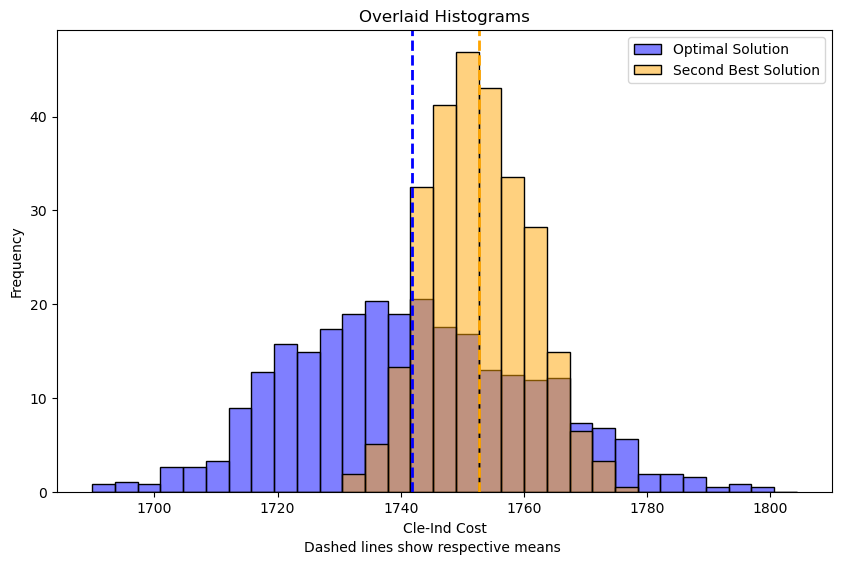

In [12]:
np.random.seed(2579)

# Number of samples to generate
n_samples = 1000

# Current cost between Cleveland and Indianapolis
mean_cost = 2.3
std_sev = 0.2
# Generate random costs using normal distribution
normal_costs = np.random.normal(loc=mean_cost, scale=std_sev, size=n_samples)

# Extract the shipment amount from Cleveland to Indianapolis for each solution
shipment_amount = sol_sim_comp.loc[('Cleveland', 'Indianapolis'), 'shipment']
shipment_amount2 = sol_sim_comp.loc[('Cleveland', 'Indianapolis'), 'shipment2']

# Find the total costs for all other shipments for each of the two solution since we are assuming they are fixed
obj1 = sum(sol_sim_comp.cost * sol_sim_comp.shipment) - shipment_amount*sol_sim_comp.loc[('Cleveland', 'Indianapolis'), 'cost']
obj2 = sum(sol_sim_comp.cost * sol_sim_comp.shipment2) - shipment_amount2*sol_sim_comp.loc[('Cleveland', 'Indianapolis'), 'cost']

# Create a DataFrame to hold total costs including the new simulated costs 
total_costs_df = pd.DataFrame({
    'Total_Cost_Sol1': obj1 + normal_costs * shipment_amount,
    'Total_Cost_Sol2': obj2 + normal_costs * shipment_amount2
})

# Determine the common range for both datasets
min_cost = min(total_costs_df['Total_Cost_Sol1'].min(), total_costs_df['Total_Cost_Sol2'].min())
max_cost = max(total_costs_df['Total_Cost_Sol1'].max(), total_costs_df['Total_Cost_Sol2'].max())

### This is code to create a visualization of each solution's variability
# Define bin width and create bins
binwidth = (max_cost - min_cost) / 30  # Adjust the divisor for desired number of bins
bins = np.arange(min_cost, max_cost + binwidth, binwidth)

# Plot the overlaid histograms with the same binwidth and range
plt.figure(figsize=(10, 6))

# Histogram for total cost using normal distribution costs
sns.histplot(total_costs_df['Total_Cost_Sol1'], bins=bins, color='blue', label='Optimal Solution',
             alpha=0.5, kde=False, stat='frequency')

# Histogram for total cost using triangular distribution costs
sns.histplot(total_costs_df['Total_Cost_Sol2'], bins=bins, color='orange', label='Second Best Solution',
             alpha=0.5, kde=False, stat='frequency')

# Add vertical lines at the means
plt.axvline(total_costs_df['Total_Cost_Sol1'].mean(), color='blue', linestyle='dashed', linewidth=2)
plt.axvline(total_costs_df['Total_Cost_Sol2'].mean(), color='orange', linestyle='dashed', linewidth=2)

plt.title('Overlaid Histograms')
plt.xlabel('Cle-Ind Cost')
plt.ylabel('Frequency')
plt.figtext(0.5, 0.01, 'Dashed lines show respective means', ha='center', fontsize=10)
plt.legend()
plt.show()


Looking at this histogram, how would you argue going forward with either solution?

### Individual chance constraint

Meeting widget demand in Nashville is now an extremely high priority. Historically, our data says that the demand here for the next sales period follows a [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution) that has a mean of 100 (in the original model, demand was 101). Fill in the code blanks below to make sure we meet the demand with probability 0.95.

In [13]:
from scipy.stats import poisson

q95 = poisson.ppf(0.95, 100)
q95

117.0

Use the demand constraint's attribute 'RHS' to quickly update the demand and use the code below to resolve and compare. 

In [14]:
meet_demand['Nashville'].RHS = q95
m.update()
m.optimize()

x_values_Nash = pd.Series(m.getAttr('X', x), name = 'shipment_Nash', index = transp_cost.index)

m_Nash_ObjVal = m.ObjVal
print(f"This model has a total cost of {round(m_Nash_ObjVal,2)}. The original model has a cost of {round(m_ObjVal,2)}")
sol_Nash = pd.concat([transp_cost, x_values_Nash], axis=1)
sol_Nash_comp = pd.concat([sol, sol_Nash.drop('cost', axis = 1)], axis=1)
sol_Nash_comp[(sol_Nash_comp.shipment > 0) | (sol_Nash_comp.shipment_Nash > 0)]


This model has a total cost of 1798.3. The original model has a cost of 1748.42


cost  shipment  shipment_Nash
production  distribution                               
Baltimore   Columbia      4.50       0.0           30.0
            Nashville     5.96      30.0            0.0
            Richmond      1.96     116.0          116.0
Cleveland   Columbia      2.43      89.0           59.0
            Indianapolis  2.37      95.0           95.0
            Nashville     4.13       0.0           37.0
Little Rock St. Louis     2.92     140.0          140.0
Birmingham  Nashville     1.53      71.0           80.0
Charleston  Lexington     1.61     121.0          121.0
            St. Louis     4.60      41.0           41.0

### Scenario Optimization

Here we build on the example from the earlier presentation where we were considering three scenarios in portfolio optimization. We'll combine the concept of scenario optimization with "maxi-min" from Opti 201. We are considering investing in seven possible sectors under three different scenarios. Below is the input data which defines the sectors, scenarios, and the respective estimated return. 

In [15]:
# Define sectors
sectors = [
    'Tech',
    'TradRetailUtil',
    'Renewable',
    'FossilFuel',
    'Auto',
    'GenHealth',
    'TradHealth'
]

# Define scenarios
scenarios = [1, 2, 3]

# Expected returns (%) for each sector under each scenario
estimated_returns = {
    ('Tech', 1): 12,
    ('Tech', 2): 1,
    ('Tech', 3): 3,
    ('TradRetailUtil', 1): 3,
    ('TradRetailUtil', 2): 4,
    ('TradRetailUtil', 3): 3,
    ('Renewable', 1): 5,
    ('Renewable', 2): 15,
    ('Renewable', 3): 4,
    ('FossilFuel', 1): 3,
    ('FossilFuel', 2): -5,
    ('FossilFuel', 3): 4,
    ('Auto', 1): 4,
    ('Auto', 2): 2,
    ('Auto', 3): 4,
    ('GenHealth', 1): 1,
    ('GenHealth', 2): 4,
    ('GenHealth', 3): 10,
    ('TradHealth', 1): 3,
    ('TradHealth', 2): 2,
    ('TradHealth', 3): -3
}

Create an optimization model where we decide the percentage of our budget to invest to **maximize the minimum** total estimated returns considering all scenarios. **HINT**: Define a single new auxiliary variable.

In [16]:
# Create a new model
m_scen = gp.Model("PortfolioOptimization")
m_scen.setParam('OutputFlag', 0)

# Decision variables: Investment fractions in each sector
x = m_scen.addVars(sectors, name="Investment", lb=0, ub=1)

# Auxiliary variable: Minimum portfolio return
z = m_scen.addVar(name="MinReturn")

# Add investment allocation constraint
m_scen.addConstr(x.sum() == 1, name="TotalInvestment")

# Add portfolio return constraints for each scenario
portfolio_return = m_scen.addConstrs((gp.quicksum(estimated_returns[(i, s)] * x[i] for i in sectors) >= z for s in scenarios), name = 'ReturnConstraint_Scenario')

# Set objective: Maximize the minimum portfolio return
m_scen.setObjective(z, GRB.MAXIMIZE)

# Optimize the model
m_scen.optimize()

print(f"Optimal objective value: {round(m_scen.ObjVal,2)}")

# Get the results
investment_allocation = pd.Series({i: round(x[i].X,3) for i in sectors}, name='Investment Allocation')
investment_allocation.to_frame()

Optimal objective value: 5.93


,Investment Allocation
Tech,0.350
TradRetailUtil,0.000
Renewable,0.271
FossilFuel,0.000
Auto,0.000
GenHealth,0.380
TradHealth,0.000


You now decide that your investments need to be a little more diversified. Add any necessary variables and constraints that will:
- Make sure you invest in at least four sectors.
- If an investment is made in a sector, then will need to be at least 10% of the budget.

In [17]:
# Add new variables and/or constraints
y = m_scen.addVars(sectors, vtype=GRB.BINARY,name='decision')

l = 0.1
m_scen.addConstrs((x[i] <= y[i] for i in sectors), name='xy_link1')
m_scen.addConstrs((x[i] >= l*y[i] for i in sectors), name='xy_link2')
m_scen.addConstr(y.sum() >= 4)
# Optimize the model
m_scen.optimize()

# Get the results
investment_allocation = pd.Series({i: round(x[i].X,3) for i in sectors}, name='Investment Allocation')
investment_allocation.to_frame()

,Investment Allocation
Tech,0.307
TradRetailUtil,0.000
Renewable,0.257
FossilFuel,0.000
Auto,0.100
GenHealth,0.336
TradHealth,0.000
